# Model training
In this notebook a model is created, trained and evaluated on the test set.
<br>MLFlow is used to track the experiments and push a model to production.

In [1]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import random
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import mlflow

from countryguess.data import Dataset, TestDataset, ValDataset, TripletDataset
from countryguess.training import TripletModel, triplet_mining, eval_fn

## Plotting datasets

### Initialise datasets

In [5]:
ref_data = Dataset()
train_data = TripletDataset()
val_data = ValDataset()
test_data = TestDataset()

### Plotting

#### Training data

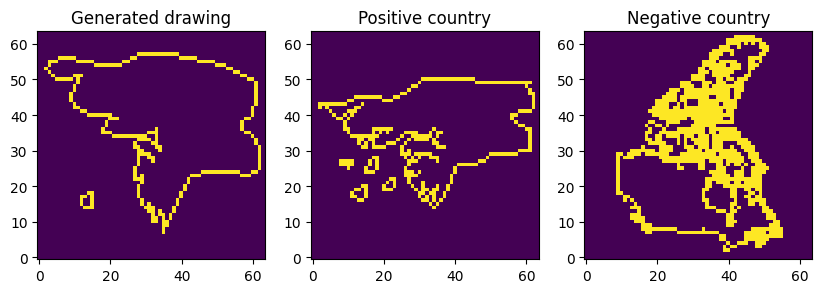

In [6]:
idx = random.randint(0, len(train_data) - 1)
sample = train_data[idx]

#Plotting
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
axs[0].imshow(sample["drawing"], interpolation='nearest', origin='lower')
axs[0].set_title("Generated drawing") 
axs[1].imshow(sample["pos_img"], interpolation='nearest', origin='lower')
axs[1].set_title("Positive country") 
axs[2].imshow(sample["neg_img"], interpolation='nearest', origin='lower')
axs[2].set_title("Negative country") 
plt.show()

#### Validation set

In [31]:
from countryguess.utils import poly_to_img

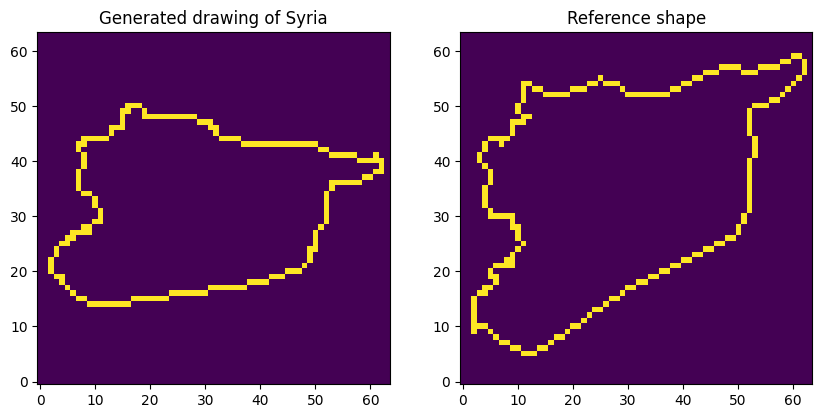

In [51]:
idx = random.randint(0, len(val_data) - 1)
sample = val_data[idx]

#Plotting
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(sample["drawing"], interpolation='nearest', origin='lower')
axs[0].set_title(f"Generated drawing of {sample['country_name']}") 

img = poly_to_img(ref_data.from_country_name(sample['country_name']), ref_data.shape)
axs[1].imshow(img, interpolation='nearest', origin='lower')
axs[1].set_title("Reference shape")
plt.show()

#### Test set (user drawings)

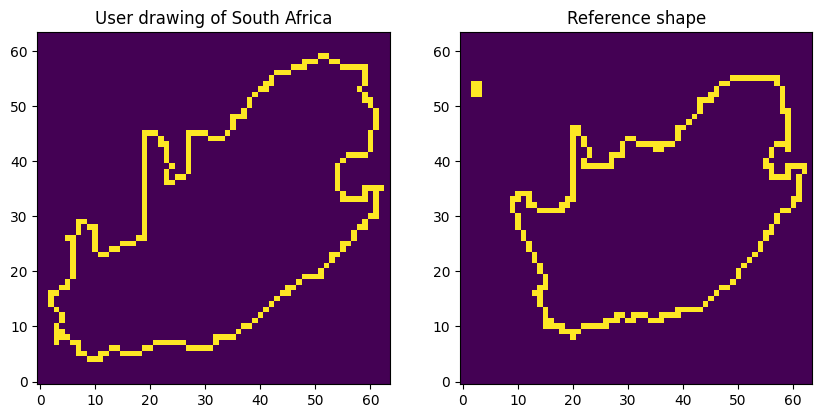

In [63]:
idx = random.randint(0, len(test_data) - 1)
sample = test_data[idx]

#Plotting
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(sample["drawing"], interpolation='nearest', origin='lower')
axs[0].set_title(f"User drawing of {sample['country_name']}") 

img = poly_to_img(ref_data.from_country_name(sample['country_name']), ref_data.shape)
axs[1].imshow(img, interpolation='nearest', origin='lower')
axs[1].set_title("Reference shape")
plt.show()

## Training model

Run the following command to start the MLFlow Tracking UI: `mlflow ui --port 5001`
<br>Access the MLFlow Tracking UI at: http://127.0.0.1:5001

In [2]:
device = torch.device("mps")

In [11]:
mlflow.set_experiment("training")

params = {"channels": 4*random.randint(1, 6),
          "nr_conv_blocks": random.randint(2, 5),
          "embedding_size": 32*random.randint(2, 7),
          "shape": 32*random.randint(2, 5),
          "learning_rate": random.uniform(0.006, 0.012), 
          "margin": random.uniform(0.5, 1.5),
          "temperature": random.uniform(0.5, 1),
          "nr_epochs": random.randint(40, 100)}
print(params)

model = TripletModel(**params).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=params['learning_rate'])
triplet_loss = nn.TripletMarginLoss(margin=params['margin'])

{'channels': 12, 'nr_conv_blocks': 4, 'embedding_size': 192, 'shape': 64, 'learning_rate': 0.011315887903993871, 'margin': 1.1473917015961184, 'temperature': 0.7082018766838398, 'nr_epochs': 42}


In [12]:
#Initialise datasets
ref_data = Dataset(shape=(params["shape"], params["shape"]))
train_data = TripletDataset(shape=(params["shape"], params["shape"]), temp=params["temperature"])
val_data = ValDataset(shape=(params["shape"], params["shape"]), temp=params["temperature"])

train_dl = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2)
val_dl = DataLoader(val_data, batch_size=32, num_workers=2)

In [13]:
with mlflow.start_run() as run:
    mlflow.log_params(params)
    
    #Start training
    for epoch in range(params['nr_epochs']):
        losses = []        
        model.train()
        for batch in train_dl:
            optimizer.zero_grad()
            anc_emb = model(batch['drawing'][:, None, :, :].type(torch.float32).to(device))
            pos_emb = model(batch['pos_img'][:, None, :, :].type(torch.float32).to(device))
            neg_emb = model(batch['neg_img'][:, None, :, :].type(torch.float32).to(device))
    
            #Mine triplets
            anc_emb, pos_emb, neg_emb = triplet_mining(anc_emb, pos_emb, neg_emb, 
                                                       batch["pos_idx"], batch["neg_idx"])
    
            loss = triplet_loss(anc_emb, pos_emb, neg_emb)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
    
        mlflow.log_metric("loss", np.mean(losses), epoch)
        
        print('Epoch: {}/{}\t loss: {:.3f}'.format(epoch+1, params['nr_epochs'], np.mean(losses)))
    
        if (epoch+1)%5==0:
            ranking = np.array([])
            model.eval()
            model.load_reference(ref_data)
            for batch in val_dl:
                rank = eval_fn(model, batch)
                ranking = np.append(ranking, rank)
    
            mlflow.log_metric("val_avg_rank", np.mean(ranking) + 1, epoch)
            mlflow.log_metric("val_top_10_acc", np.mean(ranking < 10), epoch)
            mlflow.log_metric("val_top_1_acc", np.mean(ranking < 1), epoch)
    
            print('Epoch: {}/{}\t Average rank: {:.2f}\t top 10 acc: {:.1f}%\t top 1 acc: {:.1f}%\t'
                  .format(epoch+1, params['nr_epochs'], np.mean(ranking)+1, 100*np.mean(ranking < 10), 100*np.mean(ranking < 1)))

Epoch: 1/42	 loss: 0.400
Epoch: 2/42	 loss: 0.234
Epoch: 3/42	 loss: 0.133
Epoch: 4/42	 loss: 0.128
Epoch: 5/42	 loss: 0.110
Epoch: 5/42	 Average rank: 5.65	 top 10 acc: 88.8%	 top 1 acc: 53.8%	
Epoch: 6/42	 loss: 0.083
Epoch: 7/42	 loss: 0.100
Epoch: 8/42	 loss: 0.090
Epoch: 9/42	 loss: 0.172
Epoch: 10/42	 loss: 0.076
Epoch: 10/42	 Average rank: 5.23	 top 10 acc: 90.9%	 top 1 acc: 59.4%	
Epoch: 11/42	 loss: 0.049
Epoch: 12/42	 loss: 0.081
Epoch: 13/42	 loss: 0.074
Epoch: 14/42	 loss: 0.089
Epoch: 15/42	 loss: 0.083
Epoch: 15/42	 Average rank: 4.96	 top 10 acc: 90.9%	 top 1 acc: 62.4%	
Epoch: 16/42	 loss: 0.096
Epoch: 17/42	 loss: 0.052
Epoch: 18/42	 loss: 0.058
Epoch: 19/42	 loss: 0.044
Epoch: 20/42	 loss: 0.054
Epoch: 20/42	 Average rank: 5.36	 top 10 acc: 88.8%	 top 1 acc: 62.4%	
Epoch: 21/42	 loss: 0.127
Epoch: 22/42	 loss: 0.091
Epoch: 23/42	 loss: 0.030
Epoch: 24/42	 loss: 0.045
Epoch: 25/42	 loss: 0.020
Epoch: 25/42	 Average rank: 3.64	 top 10 acc: 94.4%	 top 1 acc: 63.5%	
Epoch

### Evaluate model

In [20]:
test_data = TestDataset(shape=(params["shape"], params["shape"]))
test_dl = DataLoader(test_data, batch_size=32)

In [15]:
ranking = np.array([])
model.load_reference(ref_data)
model.eval()
country_names = []
for batch in test_dl:
    rank = eval_fn(model, batch)
    ranking = np.append(ranking, rank)
    country_names.extend(batch['country_name'])
    
with mlflow.start_run(run_id=run.info.run_id):
    mlflow.log_metric("nr_test_samples", len(test_data))
    mlflow.log_metric("test_avg_rank", np.mean(ranking) + 1)
    mlflow.log_metric("test_top_10_acc", np.mean(ranking < 10))
    mlflow.log_metric("test_top_1_acc", np.mean(ranking < 1))

In [16]:
print('Average rank: {:.2f}\t top 10 acc: {:.1f}%\t top 1 acc: {:.1f}%\t'
      .format(np.mean(ranking)+1, 100*np.mean(ranking < 10), 100*np.mean(ranking < 1))) 

Average rank: 2.68	 top 10 acc: 96.8%	 top 1 acc: 67.7%	


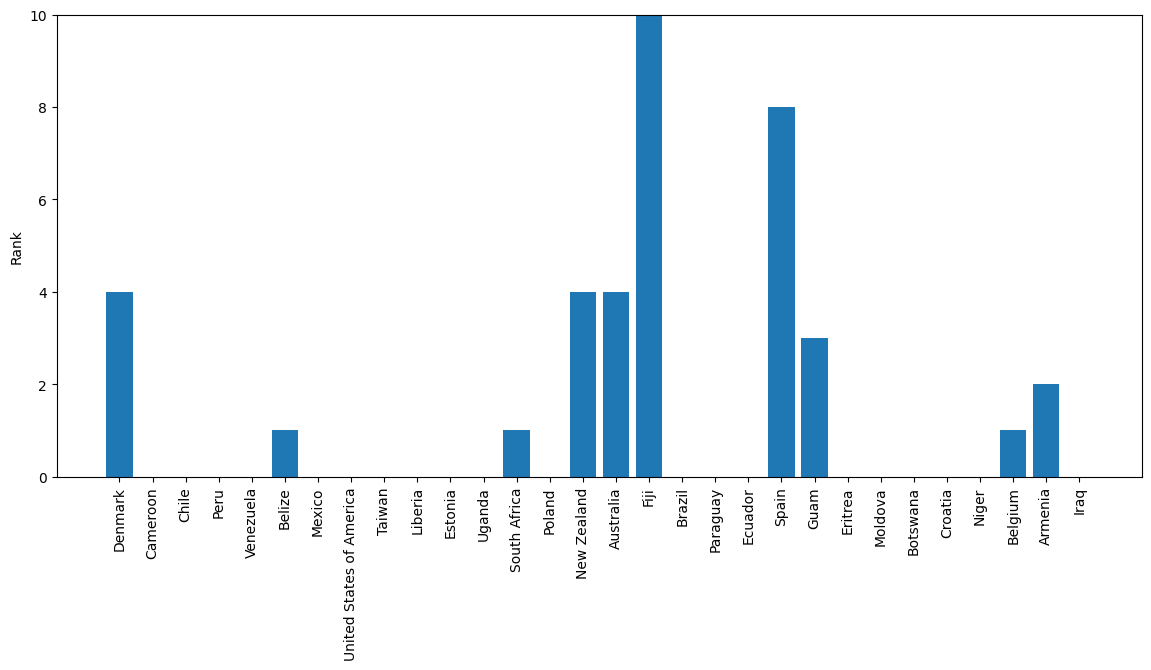

In [17]:
fig = plt.figure(figsize = (14, 6))
plt.bar(country_names, ranking)
plt.xticks(rotation=90)
plt.ylim((0, 10))
plt.ylabel("Rank")
plt.show()

### Log model

In [18]:
with mlflow.start_run(run_id=run.info.run_id):
    mlflow.pytorch.log_model(model, "model")

## Register model
Compare models and push to producton

In [108]:
#For now use the UI

In [138]:
best_run = mlflow.search_runs(order_by=["metrics.test_avg_rank ASC"]).iloc[0]
mlflow.register_model(f"runs:/{best_run.run_id}/model", "Model")

Registered model 'Model' already exists. Creating a new version of this model...
Created version '2' of model 'Model'.


<ModelVersion: aliases=[], creation_timestamp=1714761765025, current_stage='None', description=None, last_updated_timestamp=1714761765025, name='Model', run_id='e6e9ca159b304b7ab1224f65240f6d5b', run_link=None, source='file:///Users/jortdejong/GitHub/country-guess/mlruns/0/e6e9ca159b304b7ab1224f65240f6d5b/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=2>